<a href="https://colab.research.google.com/github/gaeunfalo16/Deep_Learning/blob/master/lol_datset_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **실험 내용 :**
 LOL(League of Lengend)은 블루팀과 레드팀이 상대방의 넥서스를 먼저 파괴하면 승리하는 게임이다. 승리하기 위해서는 게임에서 사용되는 다양한 변수(아이템, 부서진 타워의 개수, 챔피언, 지형 등)을 고려해야 한다. 이러한 요소들을 고려하여 블루팀이 이길지 질지(즉, 레드팀이 질지 이길지) 예측하는 다양한 모델을 구현한다. 

# 데이터 출처
https://www.kaggle.com/laurentmart/lol-first-10-minutes

# 데이터 설명
게임에 활용되는 모든 변수를 담고 있다. 와드(게임 내 사용되는 아이템)가 얼마나 많이 사용되었는지, 블루팀은 10분동안 얼마나 많이 죽었거나 혹은 상대방을 죽였는지, 어시스트는 총 몇번인지, 정글을 돌며 잡은 몬스터는 총 몇마리인지 등 게임 내 다양한 변수를 표현한 feature를 가진 .csv 형태로 저장되어 있다. 


# 실험 설계 및 방법

(데이터 전처리 없이)
0. Zero-R : 모든 모델 성능의 하한선을 제공한다. 적어도 Zero-R보다는 성능이 좋아야 한다.

1. Decision Tree : 다양한 트리 모델의 기본 구조이므로 Decision Tree 모델을 활용한 Random Forest와 Bagging과의 성능 비교를 위해 Decision Tree 모델을 선택했다.(데이터 전처리 전 실험 결과, Decision Tree의 성능이 가장 높았다. 때문에 feature selection을 적용하여 더 높은 성능을 기대해보려고 한다.)

2. Random Forest : Decision Tree모델의 앙상블 형태를 띄고 있으며 높은 성능을 보여주기 때문에 이 모델을 선택했다. (데이터 전처리 후 실험 결과, Random Forest 성능이 가장 높았다. 때문에 feature selection을 적용하여 더 높은 성능을 기대해보려 한다.)

3. Bagging : 2의 이유와 마찬가지로 Decision Tree모델을 활용하기에 Decision Tree와의 성능 비교를 위해서 이 모델을 선택했다.

4. KNN : 가장 가까운 데이터 포인트를 찾아 분류하는 모델이고 성능도 높은 편이기에 이 모델을 선택했다.

후에 1~4번 과정을 데이터 전처리 후에 다시 진행하여 데이터 전처리 전후 모델 성능을 비교한다. 

# 0. Zero-R
 성능의 척도가 되는 모델이다. 최소한 Zero-R의 성능보다는 좋아야 하므로 Zero-R 모델을 가장 먼저 적용한다. 

 


In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [118]:
# 데이터 받기 (게임 lol과 관련된 데이터셋이기 때문에 데이터 이름을 lol로 저장한다.)
lol = pd.read_csv("high_diamond_ranked_10min.csv")

In [119]:
# 데이터 첫 다섯 instance 확인
lol.head()

gameId  blueWins  ...  redCSPerMin  redGoldPerMin
0  4519157822         0  ...         19.7         1656.7
1  4523371949         0  ...         24.0         1762.0
2  4521474530         0  ...         20.3         1728.5
3  4524384067         0  ...         23.5         1647.8
4  4436033771         0  ...         22.5         1740.4

[5 rows x 40 columns]

In [ ]:
# lol 데이터는 na값이 없기 때문에 na핸들링을 하지 않아도 된다. 

gameId는 승패에 영향을 끼치지 않기 때문에 drop한다.

In [120]:
lol = lol.drop(columns=['gameId'])

In [48]:
lol.head()

blueWins  blueWardsPlaced  ...  redCSPerMin  redGoldPerMin
0         0               28  ...         19.7         1656.7
1         0               12  ...         24.0         1762.0
2         0               15  ...         20.3         1728.5
3         0               43  ...         23.5         1647.8
4         0               75  ...         22.5         1740.4

[5 rows x 39 columns]

In [49]:
# 데이터 타입 확인
lol.dtypes

blueWins                          int64
blueWardsPlaced                   int64
blueWardsDestroyed                int64
blueFirstBlood                    int64
blueKills                         int64
blueDeaths                        int64
blueAssists                       int64
blueEliteMonsters                 int64
blueDragons                       int64
blueHeralds                       int64
blueTowersDestroyed               int64
blueTotalGold                     int64
blueAvgLevel                    float64
blueTotalExperience               int64
blueTotalMinionsKilled            int64
blueTotalJungleMinionsKilled      int64
blueGoldDiff                      int64
blueExperienceDiff                int64
blueCSPerMin                    float64
blueGoldPerMin                  float64
redWardsPlaced                    int64
redWardsDestroyed                 int64
redFirstBlood                     int64
redKills                          int64
redDeaths                         int64


In [50]:
# blueWins feature(=label)을 프린트해봅니다. (만약 블루팀이 이긴다면 1, 진다면 0)
lol['blueWins']

0       0
1       0
2       0
3       0
4       0
       ..
9874    1
9875    1
9876    0
9877    0
9878    1
Name: blueWins, Length: 9879, dtype: int64

In [51]:
# blueWins는 binary 변수이고 label의 각 개수를 count / blue팀이 이긴 횟수는 4930번, 진 횟수는 4949번이다. 
lol['blueWins'].value_counts(sort=True)

0    4949
1    4930
Name: blueWins, dtype: int64

In [52]:
# TODO: 이 데이터셋에서 "Play Golf = Yes"로 예측하는 ZeroR 모델의 정확도를 계산해봅니다.
4930 / (4930 + 4949)

0.4990383642069035

**blue팀이 이길거라고 예측하는 모델의 정확도는 약 50%이다. **




# 1. Decision Tree Model

datset의 feature가 서로 독립적이라고 가정한다. feature의 수가 적은 datset에 대한 간단한 과제를 빠르고 쉽게 수행할 수 있는 모델이다. LOL datset같은 경우 feature의 수도 많고 feature가 서로 독립적이지 않기 때문에 복잡한 분류 과제다. 큰 성능을 기대하긴 어렵다. Decision Tree Model을 택한 이유는 복잡한 과제에 대해서 위에서 수행한 Zero-R보다 더 높은 성능을 보여줄 수 있을지 실험해보고 싶었다. 또한 다음 단계에서 Random Forest Model을 활용할 예정이기에 단순한 Decision Tree보다 얼마나 더 뛰어난 성능을 보이는지 확인하고 싶었다.

In [121]:
# 데이터를 train/test data로 나눈다.
from sklearn.model_selection import train_test_split 

y = lol[['blueWins']]
x = lol.drop(columns=['blueWins'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3) # test data의 비율은 전체 dataset의 30%이다.

In [54]:
# DecisionTree 오브젝트 생성
from sklearn.tree import DecisionTreeClassifier
DTclassifier = DecisionTreeClassifier()

In [55]:
# Decision Tree에 데이터를 훈련
DTclassifier.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [56]:
print(DTclassifier.score(x_test, y_test))

0.643387314439946


***Zero-R은 50%, Decision Tree는 64.3%의 성능을 기록하고 있다. Zero-R보다 Decision Tree가 14.3% 만큼 더 높은 성능을 보여주고 있는 것을 확인할 수 있다.***



In [57]:
# 결정트리의 시각화
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(DTclassifier, feature_names=x_train.columns, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('/tree.png')
Image(graph.create_png())

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.582059 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.582059 to fit



***feature의 개수가 너무 많아 과적합의 위험이 있다. 그래서 prunng(가지치기)를 해야 한다. ***

In [58]:
PDTclassifier = DecisionTreeClassifier(max_leaf_nodes=100, max_depth=10) # PDT = Pruning Decision Tree, 리프노드의 개수를 최대 100개로, 최대 깊이는 10으로 지정했다. 

PDTclassifier.fit(x_train, y_train)

print(PDTclassifier.score(x_test, y_test))

0.7101889338731444


**리프노드의 개수를 100개로 제한하여 가지치기를 한 결과 63%에서 약 71%의 성능 향상을 보인 것을 확인할 수 있다. **

[0.6913955169920463, 0.6956616052060738, 0.6984333574355265, 0.7007230657989878, 0.7026753434562545, 0.7061942636779946]
10
0.733468286099865


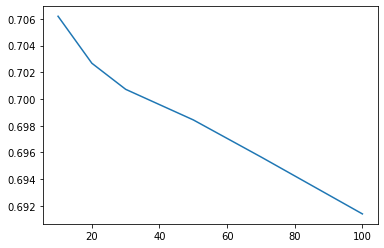

In [93]:
# max leaf node의 개수를 변화시키며 cross validation 진행 
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

max_leaf = [100, 70, 50, 30, 20, 10]
score = []
val_accuracy = np.array([])
skf = StratifiedKFold(n_splits=5)

for m in max_leaf :
    for train_index, val_index in skf.split(x_train, y_train) :
        x_train_cv, x_val_cv = x_train.iloc[train_index], x_train.iloc[val_index]
        y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
        PDTclassifier = DecisionTreeClassifier(max_leaf_nodes = m)
        PDTclassifier.fit(x_train_cv, y_train_cv)
        val_accuracy = np.append(val_accuracy, PDTclassifier.score(x_val_cv, y_val_cv))
    score.append(val_accuracy.mean())

print(score)
print(max_leaf[np.argmax(score)])
plt.plot(max_leaf, score)
PDTclassifier_final = DecisionTreeClassifier(max_leaf_nodes = max_leaf[np.argmax(score)])
PDTclassifier_final.fit(x_train, y_train)
print(PDTclassifier_final.score(x_test, y_test))

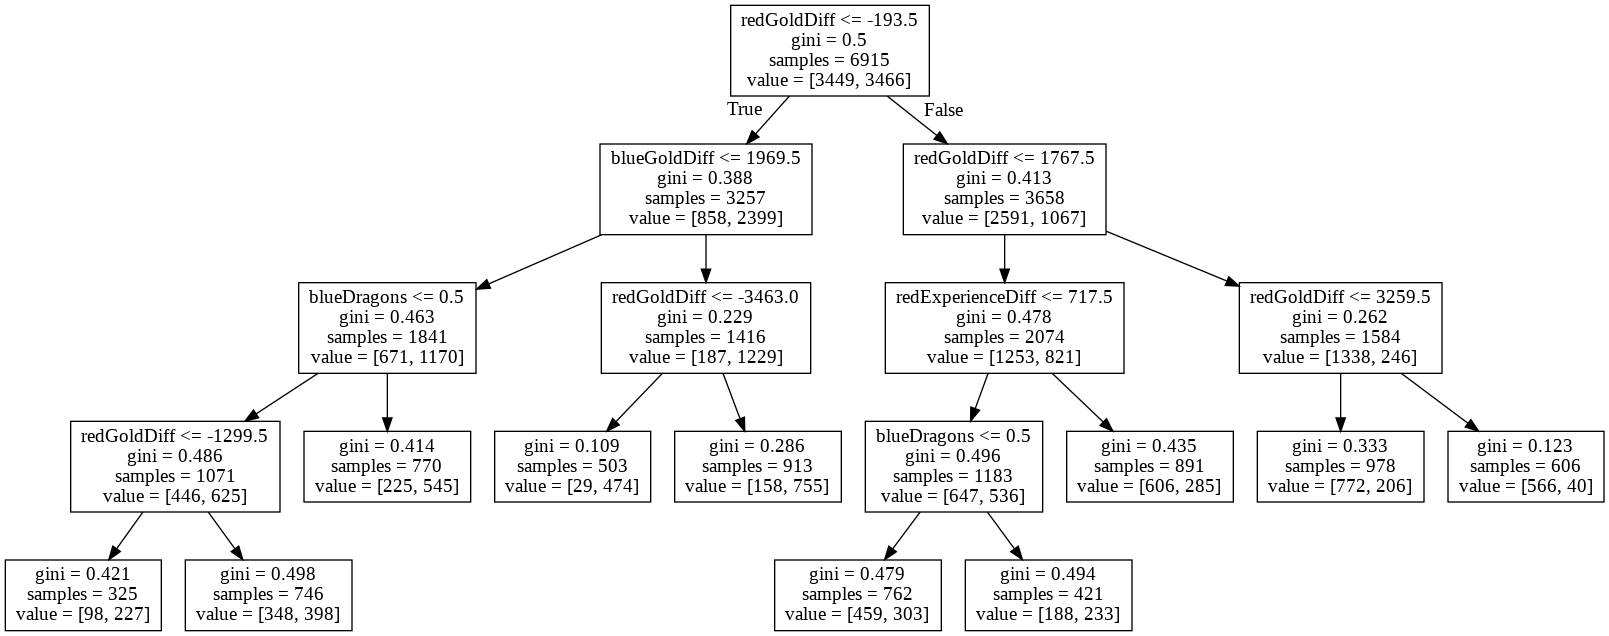

In [94]:
# Pruning Decision Tree의 시각화
dot_data = StringIO()
export_graphviz(PDTclassifier_final, feature_names=x_train.columns, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('/tree.png')
Image(graph.create_png())

# Prunning Decision Tree 모델 측정

In [70]:
y_pred = PDTclassifier_final.predict(x_test)
y_prob = PDTclassifier_final.predict_proba(x_test)[:, 1]

In [95]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[1129,  371],
       [ 424, 1040]])

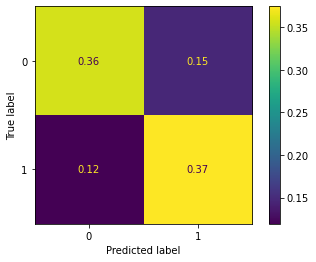

In [96]:
# Confusion Matrix의 시각화
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(PDTclassifier_final, x_test, y_test, normalize='all')

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_cm(labels, predictions):
  cm = confusion_matrix(labels, predictions)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

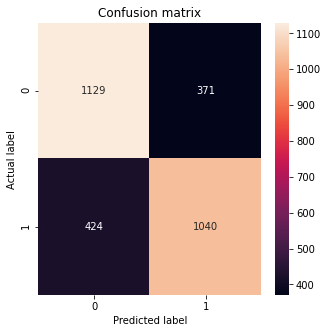

In [98]:
# plot_cm 함수를 이용한 시각화
plot_cm(y_test, y_pred)

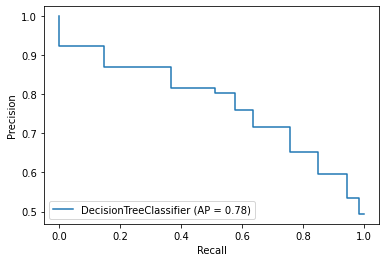

In [99]:
# precision_recall curve
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(PDTclassifier_final, x_test, y_test)

In [100]:
# ROC와 AUC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([0,100])
  plt.ylim([0,100])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

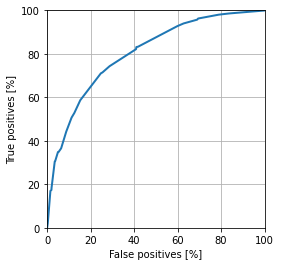

In [101]:
plot_roc('ROC Curve', y_test, y_prob)

In [102]:
# roc_auc_score
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_prob)

0.8019089253187615

In [103]:
# Decison Tree classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.75      0.74      1500
           1       0.74      0.71      0.72      1464

    accuracy                           0.73      2964
   macro avg       0.73      0.73      0.73      2964
weighted avg       0.73      0.73      0.73      2964



feature selection (반복적 특성 선택) 적용

In [231]:
from sklearn.feature_selection import RFE

select = RFE(RandomForestClassifier(n_estimators=300, random_state=42), n_features_to_select=20)
select.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RFE(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                     class_weight=None, criterion='gini',
                                     max_depth=None, max_features='auto',
                                     max_leaf_nodes=None, max_samples=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=300, n_jobs=None,
                                     oob_score=False, random_state=42,
                                     verbose=0, warm_start=False),
    n_features_to_select=20, step=1, verbose=0)

([<matplotlib.axis.YTick at 0x7fd838136940>],
 <a list of 1 Text major ticklabel objects>)

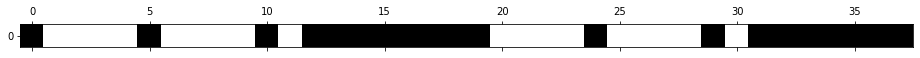

In [232]:
# 선택된 특성을 시각화
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.yticks([0])

In [234]:
# TODO: RFE를 사용해서 특성을 선택했을 때 로지스틱 회귀의 정확도를 확인해보겠습니다.
x_train_rfe = select.transform(x_train)
x_test_rfe = select.transform(x_test)

score = PDTclassifier_final.fit(x_train_rfe, y_train).score(x_test_rfe, y_test)
print(score)

0.7162618083670715


In [243]:
y_pred = PDTclassifier_final.predict(x_test_rfe)
y_prob = PDTclassifier_final.predict_proba(x_test_rfe)[:, 1]

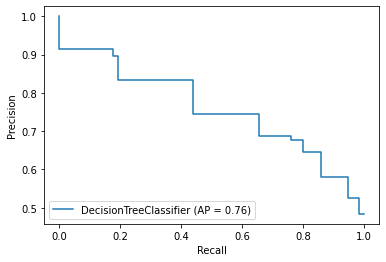

In [244]:
# precision_recall curve
plot_precision_recall_curve(PDTclassifier_final, x_test_rfe, y_test)

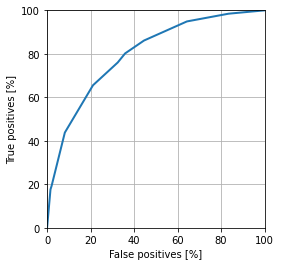

In [245]:
plot_roc('ROC Curve', y_test, y_prob)

In [246]:
# roc_auc_score
roc_auc_score(y_test, y_prob)

0.7995289468646594

In [247]:
# Decison Tree classification with feature selection
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.68      0.71      1530
           1       0.69      0.76      0.72      1434

    accuracy                           0.72      2964
   macro avg       0.72      0.72      0.72      2964
weighted avg       0.72      0.72      0.72      2964



# 2. Random Forest

랜덤 포레스트는 앙상블 모델이다. 수많은 decision tree의 결정을 모아 그 중 가장 많이 나온 결과를 택한다. 때문에 overfitting의 위험도 많이 줄어들며 decision tree보다 더 좋은 성능을 보여준다고 알려져있다.

In [106]:
from sklearn.ensemble import RandomForestClassifier

# 트리 7개로 구성된 random_forest 모델을 만들어보자. 

RFclassifier = RandomForestClassifier(n_estimators=7, random_state=42)
RFclassifier.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=7,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Random Forest의 성능은 70.4%로 Zero-R보다 20.4% 더 높다. 

In [107]:
print("Random Forest Training Set Accuracy: {:.3f}".format(RFclassifier.score(x_train, y_train)))
print("Random Forest Test Set Accuracy: {:.3f}".format(RFclassifier.score(x_test, y_test)))

Random Forest Training Set Accuracy: 0.977
Random Forest Test Set Accuracy: 0.704


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y wa

[0.6321041214750542, 0.6590744757772958, 0.6703784044348036, 0.680296456977585, 0.6876934201012292, 0.6929621595565197, 0.6972213614296044]
300


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.7243589743589743


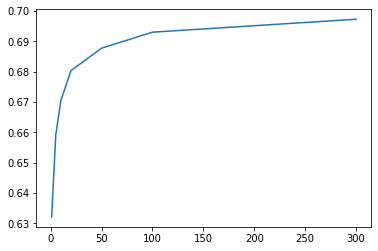

In [122]:
# cross-validation(트리의 개수를 변경할 것이다.)
from sklearn.model_selection import StratifiedKFold

n_estimator = [1, 5, 10, 20, 50, 100, 300]
score = []
val_accuracy = np.array([])
skf = StratifiedKFold(n_splits=5)

for n in n_estimator :
    for train_index, val_index in skf.split(x_train, y_train) :
        x_train_cv, x_val_cv = x_train.iloc[train_index], x_train.iloc[val_index]
        y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
        RFclassifier = RandomForestClassifier(n_estimators=n)
        RFclassifier.fit(x_train_cv, y_train_cv)
        val_accuracy = np.append(val_accuracy, RFclassifier.score(x_val_cv, y_val_cv))
    score.append(val_accuracy.mean())

print(score)
print(n_estimator[np.argmax(score)])
plt.plot(n_estimator, score)
RFclassifier_final = RandomForestClassifier(n_estimators = n_estimator[np.argmax(score)])
RFclassifier_final.fit(x_train, y_train)
print(RFclassifier_final.score(x_test, y_test))

최고 성능은 73.2%이고 tree는 300일 때 가장 성능이 좋다. 그래프가 상향곡선이므로 만약 tree의 개수을 더 증가시킨다면 성능도 올라가겠지만 큰 차이는 없을 것으로 예상된다. 

# Random Forest 모델 성능 측정

In [123]:
y_pred = RFclassifier_final.predict(x_test)
y_prob = RFclassifier_final.predict_proba(x_test)[:, 1]

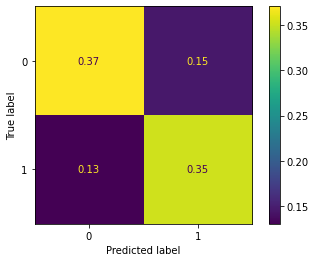

In [125]:
# confusion matrix의 시각화
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(RFclassifier_final, x_test, y_test, normalize='all')

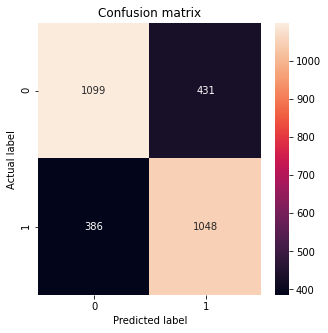

In [126]:
plot_cm(y_test, y_pred)

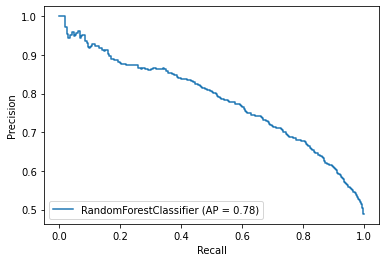

In [128]:
# precision_recall curve
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(RFclassifier_final, x_test, y_test)

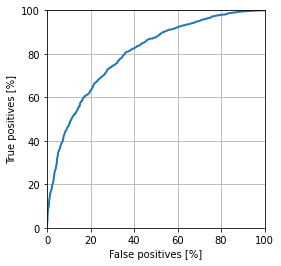

In [130]:
plot_roc('ROC Curve', y_test, y_prob)

In [131]:
# roc_auc_score
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_prob)

0.7995811341737997

In [132]:
# Random Forest classification report 출력하기
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.72      0.73      1530
           1       0.71      0.73      0.72      1434

    accuracy                           0.72      2964
   macro avg       0.72      0.72      0.72      2964
weighted avg       0.72      0.72      0.72      2964



# 3. Bagging

In [133]:
# bagging
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier

# Bagging을 사용하여 데이터셋에 LogisticRegression 모델 앙상블
Bclassifier = BaggingClassifier(LogisticRegression(), n_estimators=100, oob_score=True, n_jobs=-1, random_state=42)
Bclassifier.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BaggingClassifier(base_estimator=LogisticRegression(C=1.0, class_weight=None,
                                                    dual=False,
                                                    fit_intercept=True,
                                                    intercept_scaling=1,
                                                    l1_ratio=None, max_iter=100,
                                                    multi_class='auto',
                                                    n_jobs=None, penalty='l2',
                                                    random_state=None,
                                                    solver='lbfgs', tol=0.0001,
                                                    verbose=0,
                                                    warm_start=False),
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=1.0, n_estimators=100, n_jobs=-1, oob_score=True,
                  random_state=42, ver

In [114]:
print("Train set accuracy: {:.3f}".format(Bclassifier.score(x_train, y_train)))
print("Test set accuracy: {:.3f}".format(Bclassifier.score(x_test, y_test)))

# OOB 오차
print("OOB sample score: {:.3f}".format(Bclassifier.oob_score_))

Train set accuracy: 0.725
Test set accuracy: 0.739
OOB sample score: 0.725


성능은 73.9%로 Random Forest보다 조금(0.7%)더 좋다. 

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[0.6341287057122198, 0.6584237165582069, 0.6688840684502291, 0.6762472885032539, 0.6828344179320318, 0.6884309472161967, 0.6926970354302242]
300


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7176113360323887


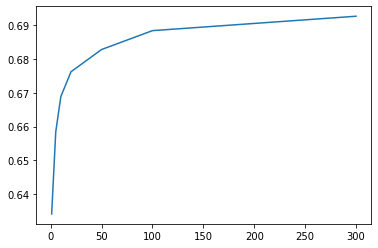

In [134]:
# cross-validation(트리의 개수를 변경할 것이다.)
from sklearn.model_selection import StratifiedKFold

n_estimator = [1, 5, 10, 20, 50, 100, 300]
score = []
val_accuracy = np.array([])
skf = StratifiedKFold(n_splits=5)

for n in n_estimator :
    for train_index, val_index in skf.split(x_train, y_train) :
        x_train_cv, x_val_cv = x_train.iloc[train_index], x_train.iloc[val_index]
        y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
        Bclassifier = BaggingClassifier(n_estimators=n)
        Bclassifier.fit(x_train_cv, y_train_cv)
        val_accuracy = np.append(val_accuracy, Bclassifier.score(x_val_cv, y_val_cv))
    score.append(val_accuracy.mean())

print(score)
print(n_estimator[np.argmax(score)])
plt.plot(n_estimator, score)
Bclassifier_final = BaggingClassifier(n_estimators = n_estimator[np.argmax(score)])
Bclassifier_final.fit(x_train, y_train)
print(Bclassifier_final.score(x_test, y_test))

Random Forest와 마찬가지로 tree의 개수가 많을수록 성능이 올라가는 것을 알 수 있다. 

# Bagging 모델 성능 측정

In [135]:
y_pred = Bclassifier_final.predict(x_test)
y_prob = Bclassifier_final.predict_proba(x_test)[:, 1]

In [136]:
# confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[1092,  438],
       [ 399, 1035]])

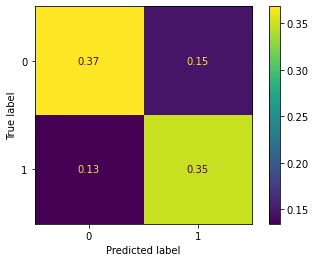

In [137]:
# confusion matrix 시각화
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(Bclassifier_final, x_test, y_test, normalize='all')

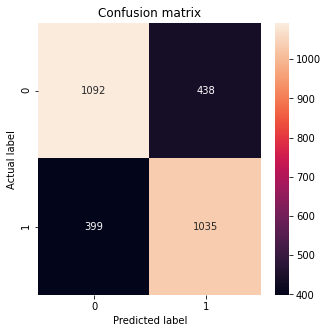

In [138]:
# plot_cm 이용해서 시각화
plot_cm(y_test, y_pred)

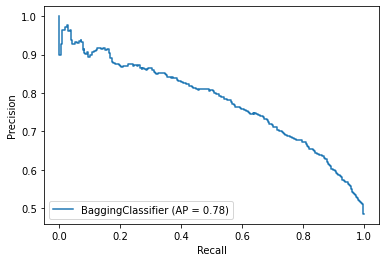

In [139]:
# precision-recall curve 
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(Bclassifier_final, x_test, y_test)

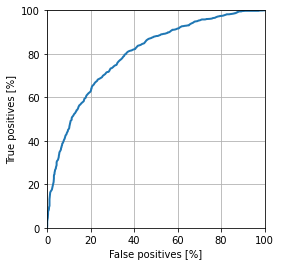

In [140]:
# roc curve 시각화
plot_roc('ROC Curve', y_test, y_prob)

In [141]:
# roc_auc_score 
roc_auc_score(y_test, y_prob)

0.7959387334664223

In [142]:
# Bagging classification report 
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.71      0.72      1530
           1       0.70      0.72      0.71      1434

    accuracy                           0.72      2964
   macro avg       0.72      0.72      0.72      2964
weighted avg       0.72      0.72      0.72      2964



# 4. KNN classifier

In [153]:
# TODO: scikit-learn의 KNN classifier을 생성하고 훈련시킵니다.
from sklearn.neighbors import KNeighborsClassifier

KNNclassifier = KNeighborsClassifier()
KNNclassifier.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [155]:
# TODO: test 셋에 대하여 정확도를 출력해봅니다.
KNNclassifier.score(x_test, y_test)

0.6885964912280702

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector 

[0.6443962400578453, 0.6409255242227043, 0.6532658471920946, 0.6579898770788141, 0.6644396240057846, 0.6693902145095205, 0.6738973246565437, 0.6773861171366594, 0.6801478267855708, 0.682530730296457, 0.6851902977716428, 0.6876355748373102]
30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.7236842105263158


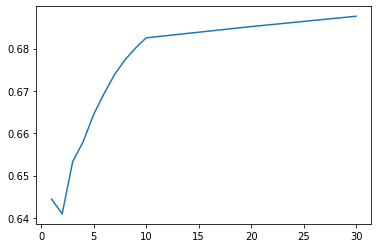

In [157]:
# cross-validation(n_neighbor의 수를 변경한다.)
from sklearn.model_selection import StratifiedKFold

n_neighbor = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30]
score = []
val_accuracy = np.array([])
skf = StratifiedKFold(n_splits=5)

for n in n_neighbor :
    for train_index, val_index in skf.split(x_train, y_train) :
        x_train_cv, x_val_cv = x_train.iloc[train_index], x_train.iloc[val_index]
        y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
        KNNclassifier = KNeighborsClassifier(n_neighbors=n)
        KNNclassifier.fit(x_train_cv, y_train_cv)
        val_accuracy = np.append(val_accuracy, KNNclassifier.score(x_val_cv, y_val_cv))
    score.append(val_accuracy.mean())

print(score)
print(n_neighbor[np.argmax(score)])
plt.plot(n_neighbor, score)
KNNclassifier_final = KNeighborsClassifier(n_neighbors = n_neighbor[np.argmax(score)])
KNNclassifier_final.fit(x_train, y_train)
print(KNNclassifier_final.score(x_test, y_test))

n_neighbors의 수를 크게 할 수록 성능이 좋아진다. 하지만 큰 차이는 없다. 

# KNN classifier 모델 성능 측정

In [158]:
y_pred = KNNclassifier.predict(x_test)
y_prob = KNNclassifier.predict_proba(x_test)[:, 1]

In [159]:
# confusion matrix

confusion_matrix(y_test, y_pred)

array([[1116,  414],
       [ 436,  998]])

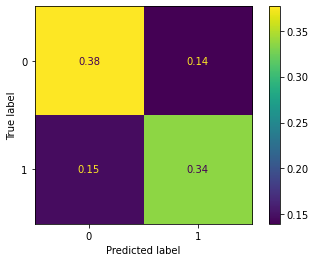

In [160]:
# confusion matrix 출력
plot_confusion_matrix(KNNclassifier, x_test, y_test, normalize='all')

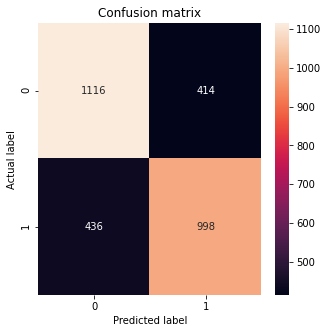

In [161]:
plot_cm(y_test, y_pred)

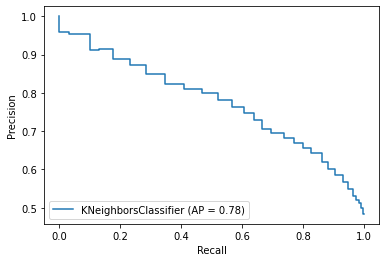

In [162]:
# precision recall curve
plot_precision_recall_curve(KNNclassifier, x_test, y_test)

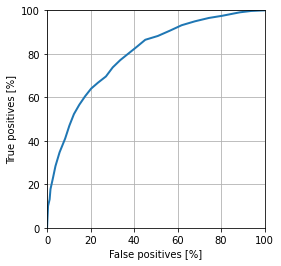

In [163]:
# roc curve 
plot_roc('ROC Curve', y_test, y_prob)

In [164]:
# roc-auc-score
roc_auc_score(y_test, y_prob)

0.7969259623886745

In [165]:
# KNN classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.73      0.72      1530
           1       0.71      0.70      0.70      1434

    accuracy                           0.71      2964
   macro avg       0.71      0.71      0.71      2964
weighted avg       0.71      0.71      0.71      2964



ROC-AUC SCORE 기준 현재까지 prunning decision tree의 성능이 가장 높다. 하지만 다른 모델과 비교했을 때의 성능 차이는 1%내로 눈에 띄게 좋은 성능을 보여주는 것은 아니다. 

# 데이터 전처리
 lol 데이터를 보면 feature의 데이터값 차이가 크다. 예를 들면 'blueKills' feature는 0~10사이의 값을 가지는데 반해 'blueTotalgold'는 10000~20000의 값을 가진다. 때문에 데이터를 동일한 범위로 맞출 필요가 있다. 이를 위해 평균과 분산을 활용해 데이터를 정규화하는 standardscaler 함수를 사용하였다. 

In [166]:
# 데이터 전처리 (정규화)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [167]:
x_scaled[:5]

array([[ 3.16995664e-01, -3.79275139e-01,  9.90429438e-01,
         9.35300855e-01, -4.69261343e-02,  1.07149547e+00,
        -8.79230989e-01, -7.53225651e-01, -4.81132421e-01,
        -2.10439033e-01,  4.60178970e-01, -1.03563482e+00,
        -7.40639346e-01, -9.92781996e-01, -1.46595148e+00,
         2.56228388e-01,  1.33420105e-02, -9.92781996e-01,
         4.60178970e-01, -3.99206522e-01,  1.53249299e+00,
        -9.90429438e-01, -4.69261343e-02,  9.35300855e-01,
         3.29496150e-01, -9.14893437e-01, -8.38965673e-01,
        -4.36494946e-01, -1.98352875e-01,  5.22926764e-02,
        -4.10474889e-01, -7.63214598e-01, -9.28740596e-01,
         3.67684541e-01, -2.56228388e-01, -1.33420105e-02,
        -9.28740596e-01,  5.22926764e-02],
       [-5.70992189e-01, -8.39068868e-01, -1.00966304e+00,
        -3.93216348e-01, -3.87796193e-01, -4.04768359e-01,
        -8.79230989e-01, -7.53225651e-01, -4.81132421e-01,
        -2.10439033e-01, -1.16679157e+00, -1.03563482e+00,
        -1.38

In [168]:
round(x_scaled.mean(), 2), x_scaled.std()

(0.0, 1.0)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


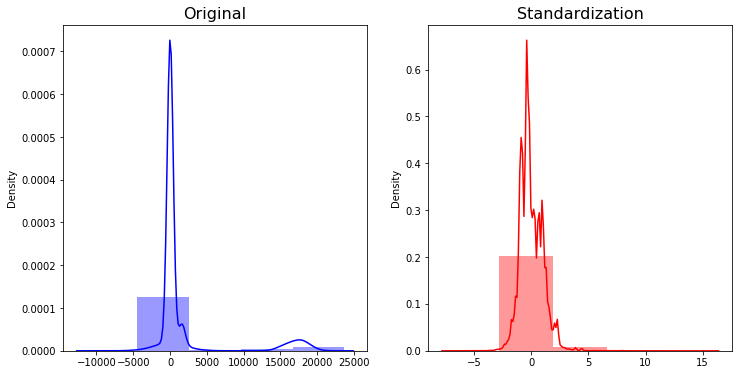

In [169]:
# 정규화된 데이터 그래프로 보기
import seaborn as sns

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.distplot(x, bins=5, color='b')
plt.title('Original', fontsize=16)

plt.subplot(1, 2, 2)
sns.distplot(x_scaled, bins=5, color='r')
plt.title('Standardization', fontsize=16)
plt.show()

In [171]:
# 다시 train/test 셋으로 나눈다.
x_scaled_train, x_scaled_test, y_scaled_train, y_scaled_test = train_test_split(x_scaled, y, test_size = 0.3, random_state=42, shuffle=True)

# 1. Decision Tree

[0.6980477223427333, 0.6980477223427333, 0.7019522776572668, 0.7047722342733188, 0.7073029645697758, 0.709472161966739]
10
0.717948717948718


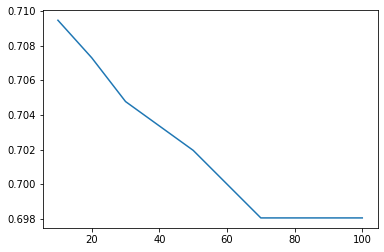

In [248]:
# max leaf node의 개수를 변화시키며(Pruning) cross validation 진행 
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

max_leaf = [100, 70, 50, 30, 20, 10]
score = []
val_accuracy = np.array([])
skf = StratifiedKFold(n_splits=5)

for m in max_leaf :
    for train_index, val_index in skf.split(x_train, y_train) :
        x_train_cv, x_val_cv = x_scaled_train[train_index], x_scaled_train[val_index]
        y_train_cv, y_val_cv = y_scaled_train.iloc[train_index], y_scaled_train.iloc[val_index]
        PDTclassifier = DecisionTreeClassifier(max_leaf_nodes = m)
        PDTclassifier.fit(x_train_cv, y_train_cv)
        val_accuracy = np.append(val_accuracy, PDTclassifier.score(x_val_cv, y_val_cv))
    score.append(val_accuracy.mean())

print(score)
print(max_leaf[np.argmax(score)])
plt.plot(max_leaf, score)
PDTclassifier_final = DecisionTreeClassifier(max_leaf_nodes = max_leaf[np.argmax(score)])
PDTclassifier_final.fit(x_scaled_train, y_scaled_train)
print(PDTclassifier_final.score(x_scaled_test, y_scaled_test))

max_leaf_nodes가 10개일 때 성능이 71%로 가장 높은 것을 확인할 수 있다. 하지만 데이터 전처리 이전의 정확도는 73.3%였으므로 오히려 데이터 전처리 후 성능이 더 낮아졌다. 

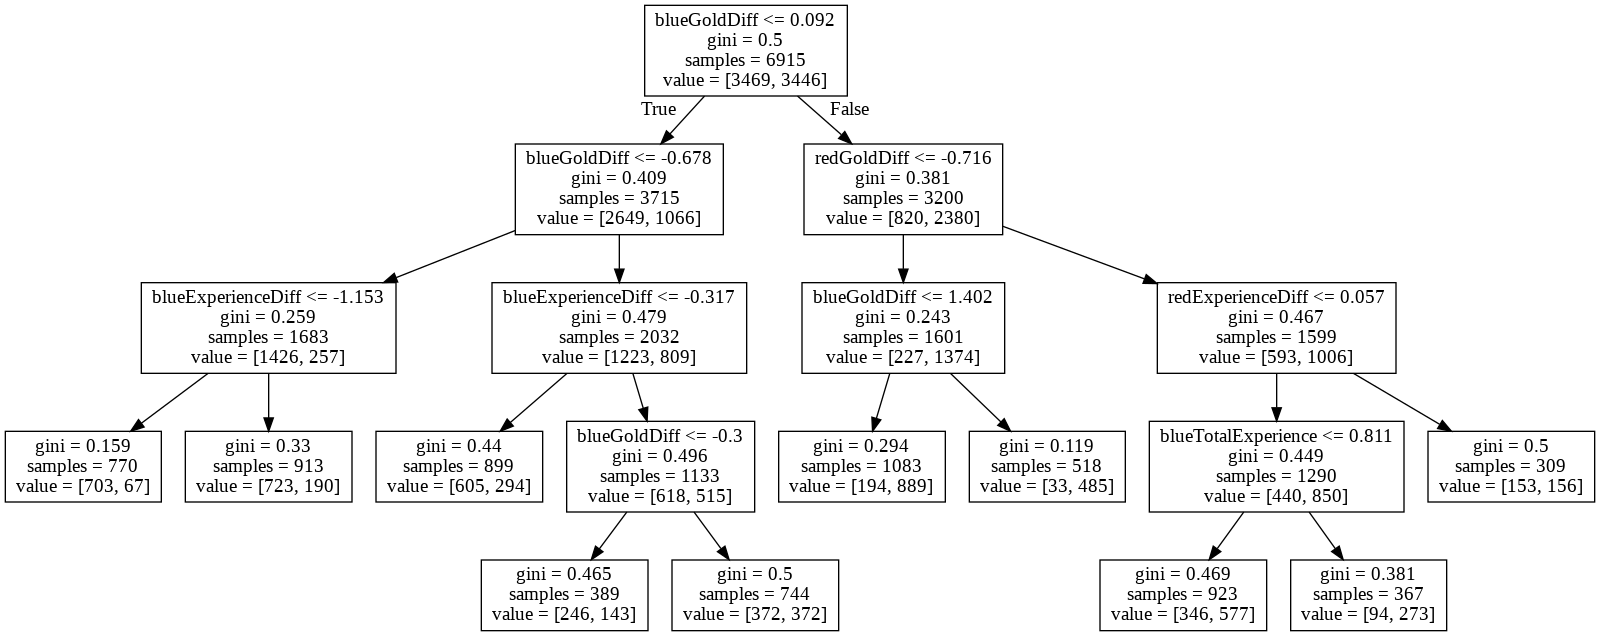

In [249]:
# Pruning Decision Tree의 시각화
dot_data = StringIO()
export_graphviz(PDTclassifier_final, feature_names=x_train.columns, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('/tree.png')
Image(graph.create_png())

# Decision Tree Model with Preprocess Data 모델 성능 측정

In [175]:
y_pred = PDTclassifier_final.predict(x_scaled_test)
y_prob = PDTclassifier_final.predict_proba(x_scaled_test)[:, 1]

In [176]:
confusion_matrix(y_test, y_pred)

array([[834, 696],
       [772, 662]])

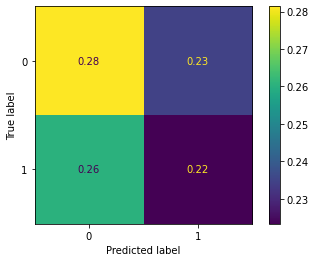

In [177]:
# confusion matrix 시각화
plot_confusion_matrix(PDTclassifier_final, x_scaled_test, y_test, normalize='all')

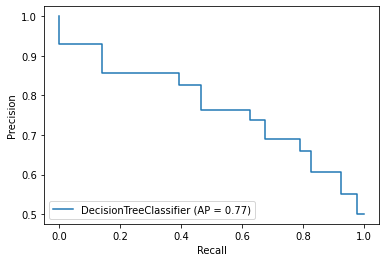

In [180]:
# precision-recall curve
plot_precision_recall_curve(PDTclassifier_final, x_scaled_test, y_scaled_test)

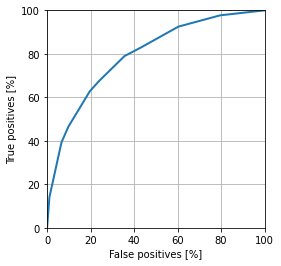

In [181]:
# roc curve
plot_roc('ROC Curve', y_scaled_test, y_prob)

In [183]:
# roc-auc score
roc_auc_score(y_scaled_test, y_prob)

0.7930756902455016

In [184]:
# Prunning Decision Tree with preprocess data report
print(classification_report(y_scaled_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.76      0.73      1480
           1       0.74      0.68      0.71      1484

    accuracy                           0.72      2964
   macro avg       0.72      0.72      0.72      2964
weighted avg       0.72      0.72      0.72      2964



Decision Tree 모델은 데이터 전처리를 했을 때 성능이 더 떨어졌다. 데이터 값을 통계에 따라 일정 범위 안에 맞췄기 때문에 일정 범위에 따라 데이터를 나눌 때 데이터 전처리 전보다 더 자세하지 않아서 그렇다고 생각한다. 

# 2. Random Forest Model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y wa

[0.6354302241503976, 0.6567606652205351, 0.6693179079296215, 0.6781634128705712, 0.6865075921908894, 0.6912509038322489, 0.69587852494577]
300


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.7219973009446694


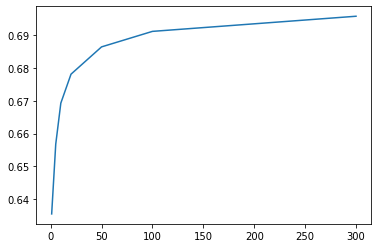

In [186]:
# cross-validation(트리의 개수를 변경할 것이다.)
from sklearn.model_selection import StratifiedKFold

n_estimator = [1, 5, 10, 20, 50, 100, 300]
score = []
val_accuracy = np.array([])
skf = StratifiedKFold(n_splits=5)

for n in n_estimator :
    for train_index, val_index in skf.split(x_train, y_train) :
        x_train_cv, x_val_cv = x_scaled_train[train_index], x_scaled_train[val_index]
        y_train_cv, y_val_cv = y_scaled_train.iloc[train_index], y_scaled_train.iloc[val_index]
        RFclassifier = RandomForestClassifier(n_estimators=n)
        RFclassifier.fit(x_train_cv, y_train_cv)
        val_accuracy = np.append(val_accuracy, RFclassifier.score(x_val_cv, y_val_cv))
    score.append(val_accuracy.mean())

print(score)
print(n_estimator[np.argmax(score)])
plt.plot(n_estimator, score)
RFclassifier_final = RandomForestClassifier(n_estimators = n_estimator[np.argmax(score)])
RFclassifier_final.fit(x_scaled_train, y_scaled_train)
print(RFclassifier_final.score(x_scaled_test, y_scaled_test))

데이터 전처리 전보다 성능이 0.3% 줄었다. 하지만 이번에는 반대로 Decision Tree Model보다 성능이 더 높게 나왔다. 

# Random Forest with preprocess data 모델 성능 측정

In [187]:
y_pred = RFclassifier_final.predict(x_scaled_test)
y_prob = RFclassifier_final.predict_proba(x_scaled_test)[:, 1]

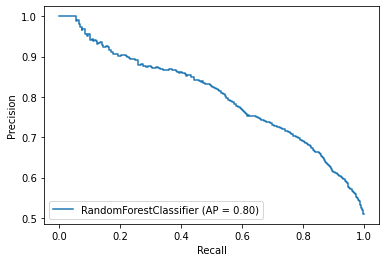

In [188]:
# precision-recall curve
plot_precision_recall_curve(RFclassifier_final, x_scaled_test, y_scaled_test)

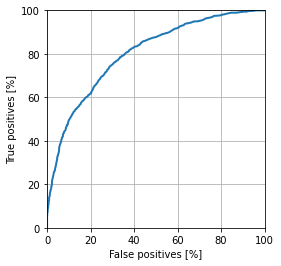

In [189]:
# roc curve
plot_roc('ROC Curve', y_scaled_test, y_prob)

In [190]:
# roc-auc score
roc_auc_score(y_scaled_test, y_prob)

0.801162854228892

In [191]:
# Random Forest with preprocess data report
print(classification_report(y_scaled_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.74      0.73      1480
           1       0.73      0.71      0.72      1484

    accuracy                           0.72      2964
   macro avg       0.72      0.72      0.72      2964
weighted avg       0.72      0.72      0.72      2964



feature selection(반복적 특성 선택) 적용

In [235]:
select = RFE(RandomForestClassifier(n_estimators=300, random_state=42), n_features_to_select=20)
select.fit(x_scaled_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RFE(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                     class_weight=None, criterion='gini',
                                     max_depth=None, max_features='auto',
                                     max_leaf_nodes=None, max_samples=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=300, n_jobs=None,
                                     oob_score=False, random_state=42,
                                     verbose=0, warm_start=False),
    n_features_to_select=20, step=1, verbose=0)

([<matplotlib.axis.YTick at 0x7fd836ac4198>],
 <a list of 1 Text major ticklabel objects>)

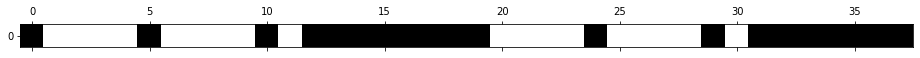

In [236]:
# 선택된 특성을 시각화
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.yticks([0])

In [237]:
# TODO: RFE를 사용해서 특성을 선택했을 때 로지스틱 회귀의 정확도를 확인해보겠습니다.
x_scaled_train_rfe = select.transform(x_scaled_train)
x_scaled_test_rfe = select.transform(x_scaled_test)

score = RFclassifier_final.fit(x_scaled_train_rfe, y_scaled_train).score(x_scaled_test_rfe, y_scaled_test)
print(score)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


0.7159244264507423


In [238]:
y_pred = RFclassifier_final.predict(x_scaled_test_rfe)
y_prob = RFclassifier_final.predict_proba(x_scaled_test_rfe)[:, 1]

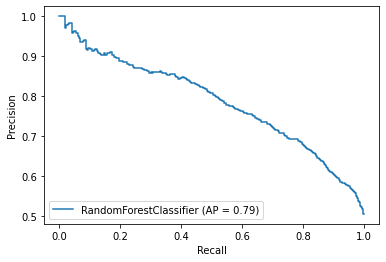

In [239]:
# precision-recall curve
plot_precision_recall_curve(RFclassifier_final, x_scaled_test_rfe, y_scaled_test)

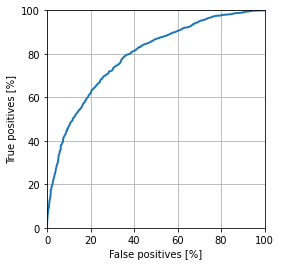

In [240]:
# roc curve
plot_roc('ROC Curve', y_scaled_test, y_prob)

In [241]:
# roc-auc score
roc_auc_score(y_scaled_test, y_prob)

0.7898268467254317

In [242]:
# Random Forest with preprocess data report
print(classification_report(y_scaled_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.73      0.72      1480
           1       0.72      0.70      0.71      1484

    accuracy                           0.72      2964
   macro avg       0.72      0.72      0.72      2964
weighted avg       0.72      0.72      0.72      2964



# 3. Bagging

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[0.6322487346348518, 0.6543745480838756, 0.6657507833212823, 0.674765003615329, 0.6819088937093275, 0.6877319836105086, 0.6917054023344695]
300


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.713225371120108


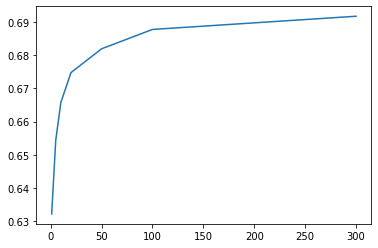

In [250]:
# cross-validation(트리의 개수를 변경할 것이다.)
from sklearn.model_selection import StratifiedKFold

n_estimator = [1, 5, 10, 20, 50, 100, 300]
score = []
val_accuracy = np.array([])
skf = StratifiedKFold(n_splits=5)

for n in n_estimator :
    for train_index, val_index in skf.split(x_train, y_train) :
        x_train_cv, x_val_cv = x_scaled_train[train_index], x_scaled_train[val_index]
        y_train_cv, y_val_cv = y_scaled_train.iloc[train_index], y_scaled_train.iloc[val_index]
        Bclassifier = BaggingClassifier(n_estimators=n)
        Bclassifier.fit(x_train_cv, y_train_cv)
        val_accuracy = np.append(val_accuracy, Bclassifier.score(x_val_cv, y_val_cv))
    score.append(val_accuracy.mean())

print(score)
print(n_estimator[np.argmax(score)])
plt.plot(n_estimator, score)
Bclassifier_final = BaggingClassifier(n_estimators = n_estimator[np.argmax(score)])
Bclassifier_final.fit(x_scaled_train, y_scaled_train)
print(Bclassifier_final.score(x_scaled_test, y_scaled_test))

# Bagging 모델 성능 측정

In [203]:
y_pred = Bclassifier_final.predict(x_scaled_test)
y_prob = Bclassifier_final.predict_proba(x_scaled_test)[:, 1]

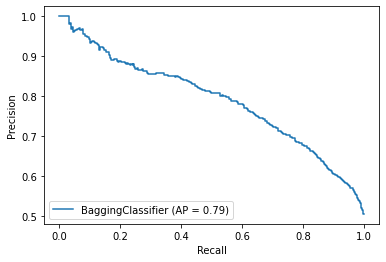

In [204]:
# precision-recall curve
plot_precision_recall_curve(Bclassifier_final, x_scaled_test, y_scaled_test)

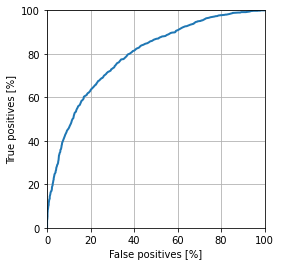

In [205]:
# roc curve
plot_roc('ROC Curve', y_scaled_test, y_prob)

In [206]:
# roc-auc score
roc_auc_score(y_scaled_test, y_prob)

0.7927266973847162

In [207]:
# Bagging Tree with preprocess data report
print(classification_report(y_scaled_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.73      0.72      1480
           1       0.72      0.71      0.72      1484

    accuracy                           0.72      2964
   macro avg       0.72      0.72      0.72      2964
weighted avg       0.72      0.72      0.72      2964



# 4. KNN

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector 

[0.6368763557483732, 0.638177874186551, 0.6489274523981682, 0.6537960954446854, 0.6604483007953723, 0.6647143890093999, 0.6691250903832249, 0.6729211858279103, 0.6761147264401061, 0.6782646420824295, 0.6811148359955302, 0.6838274282959749]
30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.7213225371120108


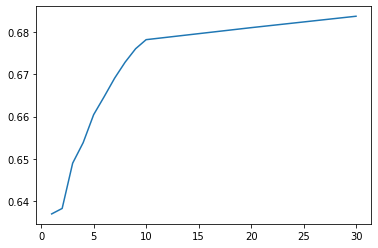

In [198]:
# cross-validation(n_neighbor의 수를 변경한다.)
from sklearn.model_selection import StratifiedKFold

n_neighbor = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30]
score = []
val_accuracy = np.array([])
skf = StratifiedKFold(n_splits=5)

for n in n_neighbor :
    for train_index, val_index in skf.split(x_train, y_train) :
        x_train_cv, x_val_cv = x_scaled_train[train_index], x_scaled_train[val_index]
        y_train_cv, y_val_cv = y_scaled_train.iloc[train_index], y_scaled_train.iloc[val_index]
        KNNclassifier = KNeighborsClassifier(n_neighbors=n)
        KNNclassifier.fit(x_train_cv, y_train_cv)
        val_accuracy = np.append(val_accuracy, KNNclassifier.score(x_val_cv, y_val_cv))
    score.append(val_accuracy.mean())

print(score)
print(n_neighbor[np.argmax(score)])
plt.plot(n_neighbor, score)
KNNclassifier_final = KNeighborsClassifier(n_neighbors = n_neighbor[np.argmax(score)])
KNNclassifier_final.fit(x_scaled_train, y_scaled_train)
print(KNNclassifier_final.score(x_scaled_test, y_scaled_test))

# KNN 모델 성능 측정

In [201]:
y_pred = KNNclassifier_final.predict(x_scaled_test)
y_prob = KNNclassifier_final.predict_proba(x_scaled_test)[:, 1]

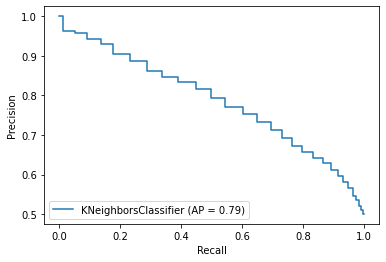

In [202]:
# precision-recall curve
plot_precision_recall_curve(KNNclassifier_final, x_scaled_test, y_scaled_test)

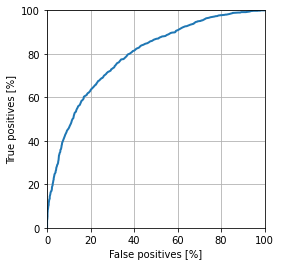

In [208]:
# roc curve
plot_roc('ROC Curve', y_scaled_test, y_prob)

In [209]:
# roc-auc score
roc_auc_score(y_scaled_test, y_prob)

0.7927266973847162

In [210]:
# Bagging Tree with preprocess data report
print(classification_report(y_scaled_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.73      0.72      1480
           1       0.72      0.71      0.72      1484

    accuracy                           0.72      2964
   macro avg       0.72      0.72      0.72      2964
weighted avg       0.72      0.72      0.72      2964



# Cluestering

In [31]:
lol.fillna(lol.mean(), inplace=True)

In [35]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2) # init=k-means++
kmeans.fit(x_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [36]:
# samples 데이터에 레이블을 부여하고, labels를 출력해봅니다.
labels = kmeans.predict(x_train)
print(labels)

[0 1 0 ... 0 0 0]


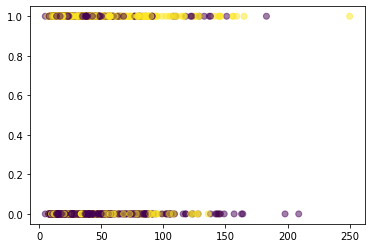

In [37]:
# 클러스터의 시각화
plt.scatter(x_train.iloc[:, 0], y_train, c=labels, alpha=0.5)
plt.show()

In [41]:
labels = kmeans.predict(x_test)
print(labels)

[0 1 0 ... 0 0 1]


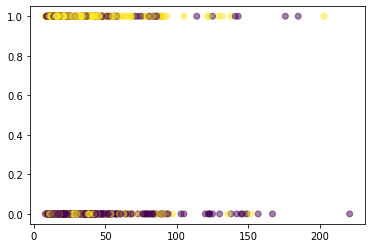

In [42]:
plt.scatter(x_test.iloc[:, 0], y_test, c=labels, alpha=0.5)
plt.show()

In [251]:
# scaled된 데이터

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2) # init=k-means++
kmeans.fit(x_scaled_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [252]:
# samples 데이터에 레이블을 부여하고, labels를 출력해봅니다.
labels = kmeans.predict(x_scaled_train)
print(labels)

[0 0 0 ... 0 1 1]


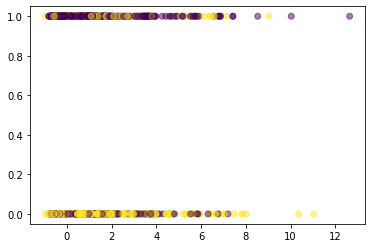

In [254]:
# 클러스터의 시각화
plt.scatter(x_scaled_train[:, 0], y_scaled_train, c=labels, alpha=0.5)
plt.show()

In [255]:
#scaled_test 정보
labels = kmeans.predict(x_scaled_test)
print(labels)

[1 0 0 ... 0 1 0]


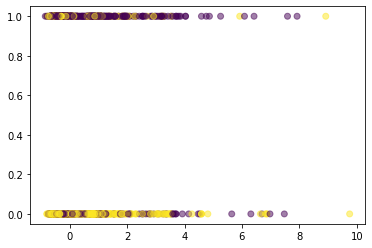

In [256]:
plt.scatter(x_scaled_test[:, 0], y_scaled_test, c=labels, alpha=0.5)
plt.show()

[데이터 전처리 전]
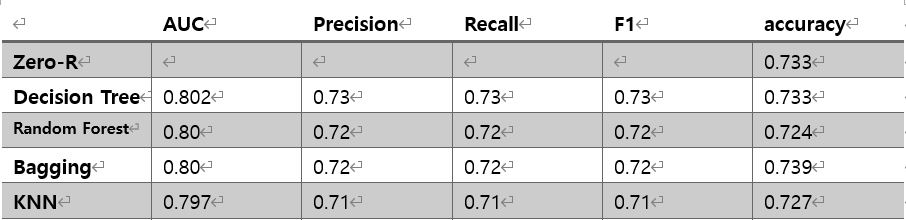

Decision Tree의 성능이 가장 높은 것을 확인할 수 있다. Decision Tree는 max_leaf_nodes가 10개일 때 성능이 가장 좋았다. 물론 다른 모델이 Decision Tree보다 전체적인 수치가 낮게 나왔지만 모두 1%이내로 큰 차이를 보여주진 않고 있다. 이는 dataset 자체의 문제라고 생각한다. 
 사실 lol이라는 게임은 초반 10분이 아니라 후반부에서도 역전할 가능성이 아주 큰 게임이다. 실제로 게임을 해보고, 혹은 경기를 봤을 때도 10분동안 밀리고 있던 팀이 다른 여러 요소로 게임 결과를 뒤집은 경우가 아주 많다. 
 만약 데이터셋이 게임 초반 10분이 아니라 게임의 전체 시간을 토대로 했다면 예상대로 Random Forest, Bagging, KNN의 성능이 가장 높게 나왔을 것이다. 하지만 게임 초반 10분만 봤기에 전체적인 성능 자체가 낮은 것이라고 판단한다. 데이터 전처리 전에는 Decision Tree의 성능이 가장 높게 나왔기 때문에 이 모델에 20개의 feature를 뽑는 feature selection을 적용했다. (전체 feature의 수는 38개이다.) 하지만 결과는 예상과 달리 auc:0.80/prediciont:0.72/recall:0.72/f1:0.72/accuracy:0.716 이라는 다소 낮은 결과가 나왔다. 이는 예상보다 많은 feature가 성능에 큰 영향을 미치고 있다는 뜻으로 해석된다. 

 

[데이터 전처리 후]
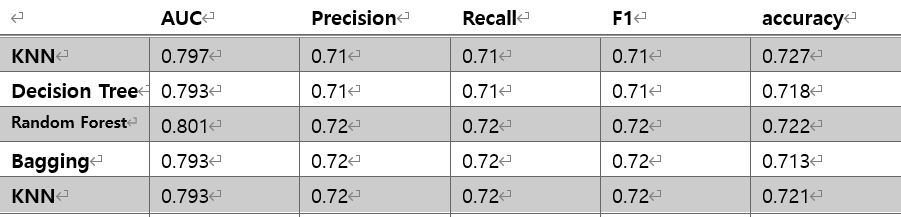

 범위를 모두 동일하게 만드는 standard scaler를 적용하자 오히려 성능이 조금 떨어졌다. 그 차이는 대부분 1% 미만이다. 즉, 데이터 전처리 전과 후에 큰 차이가 없는 것이다. 아까도 언급했던 것처럼 데이터셋의 큰 특징 중 하나인 "얼마든지 역전 가능한 게임" 이라는 점이 성능을 결정짓는 가장 큰 요소인 것 같다. 실제로 게임 후반부에 얻는 용과 바론의 효과가 매우 크기 때문이다. 
 혹은 데이터 전처리 함수를 다른 것을 써야했을 수도 있다. standard scaler를 쓴 이유는 다른 스케일러 함수보다 데이터를 고르게 분포시킬 수 있기때문이었다. 그러나 이상치가 있다면 평균과 표준편차가 이상치에 overfitting되어 잘못 편향될 수 있다고 한다. 만약 이 수많은 데이터 중에 이상치가 꽤 많이 존재한다면 데이터 전처리 이후 성능이 떨어질 수 있다. 때문에 거의 10000개나 되는 열을 모두 확인할 수 없지만 데이터 중 이상치가 있다고 추측할 수 있다. 
  데이터 전처리 후에는 Random Forest가 가장 높은 성능을 보여준다. 하지만 데이터 전처리 이전보다 0.2%낮은 수치이다. 모든 앙상블 모델은 tree의 개수가 많을 수록 높은 성능을 보여줬다. 많을수록 overfitting된 결과를 무시할 확률이 높기 때문이다. Random Forest에 feature selection을 적용한 결과 auc:0.790/prediction:0.72/recall:0.72/f1:0.72/accuracy:0.716을 기록했다. 아까보다도 다소 낮은 경향을 보여준다. 
   아까 말했듯이 데이터셋의 feature가 모두 서로 연관되어 있으며 생각보다 많은 feature가 성능에 큰 영향을 미치고 있기 때문이다. 

[clustering]

clustering 결과는 scaled data로 진행하는 것이 더 잘 cluster 된 것으로 보인다. 놀랍게도 데이터 포인트들은 y값으로 전부 0아니면 1의 값을 가지는 것을 확인할 수 있다. 이러한 점은 classification 모델과도 다르지 않다. 

# 결론

 lol이라는 게임을 좋아해서 선택한 dataset이지만 아쉬운 점이 많았다. 후반부 정보가 정말 중요한 게임임에도 초반 10분 정보로 결과를 예측해야 한다는 점이 특히 그랬다. 때문에 전체적인 성능이 낮게 나온 점이 많이 아쉬웠다. 만약 충분한 시간과 자본이 있다면 전체 게임 시간 내 모든 정보를 수집하여 최소 30분 동안의 정보를 수집하여 게임 결과를 예측하는 모델을 만들고 싶다. 